In [1]:
import pandas as pd
import datetime as dp
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from prettytable import PrettyTable
import re

In [2]:
dataset_path = 'E:/Datasets/titanic/raw dataset'

In [3]:
train_raw = pd.read_csv(f'{dataset_path}/train.csv')
test_raw = pd.read_csv(f'{dataset_path}/test.csv')

# Summary

In [4]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def count_infs(series):
    if pd.api.types.is_numeric_dtype(series):
        return np.isinf(series).sum()
    return 0

summary = pd.DataFrame({
    'dtype': train_raw.dtypes,
    'n_nans': train_raw.isna().sum(),
    'n_infs': train_raw.apply(count_infs)
})
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'column'}, inplace=True)
print(summary)

         column    dtype  n_nans  n_infs
0   PassengerId    int64       0       0
1      Survived    int64       0       0
2        Pclass    int64       0       0
3          Name   object       0       0
4           Sex   object       0       0
5           Age  float64     177       0
6         SibSp    int64       0       0
7         Parch    int64       0       0
8        Ticket   object       0       0
9          Fare  float64       0       0
10        Cabin   object     687       0
11     Embarked   object       2       0


Same for the test set

In [6]:
summary = pd.DataFrame({
    'dtype': test_raw.dtypes,
    'n_nans': test_raw.isna().sum(),
    'n_infs': test_raw.apply(count_infs)
})
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'column'}, inplace=True)
print(summary)

         column    dtype  n_nans  n_infs
0   PassengerId    int64       0       0
1        Pclass    int64       0       0
2          Name   object       0       0
3           Sex   object       0       0
4           Age  float64      86       0
5         SibSp    int64       0       0
6         Parch    int64       0       0
7        Ticket   object       0       0
8          Fare  float64       1       0
9         Cabin   object     327       0
10     Embarked   object       0       0


In [7]:
all_columns = train_raw.columns
feature_names = all_columns[~np.isin(all_columns, ['Survived', 'PassengerId', 'Name'])] #All columns that will be used for prediction

In [8]:
train_raw[feature_names].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


For starts 5 numerical values are recognized by Pandas. We could arge that the class of the passengers is a categorical ordinal value, but we already have it encoded so no problem there.

In [9]:
train_raw[feature_names].describe(include='object')

,Sex,Ticket,Cabin,Embarked
count,891,891,204,889
unique,2,681,147,3
top,male,347082,G6,S
freq,577,7,4,644


All of the three initial categorical values are cardinals

In [10]:
train_raw.duplicated().sum()

np.int64(0)

In [11]:
test_raw.duplicated().sum()

np.int64(0)

No duplicated values

# Wrangling

I'll start wrangling the dataset a little bit.
Let's map the sex column to a numerical value:

In [12]:
train_w = train_raw.copy()
test_w = test_raw.copy()
train_w['Sex'] = train_w['Sex'].map({'male': 0, 'female': 1})
test_w['Sex'] = test_w['Sex'].map({'male': 0, 'female': 1})

There are three columns with missing data. I could simply drop the two rows for the embarked column, it won't do much difference.

In [13]:
#train_w = train_w.dropna(subset=['Embarked']) #I could simply drop the two rows for the embarked column, it won't do much difference.
train_w.loc[train_w['Embarked'].isna(), 'Embarked'] = 'S' #But I replace it with the mode instead

In [14]:
train_w.loc[:, 'Cabin'] = train_w['Cabin'].fillna('unknown')
test_w.loc[:, 'Cabin'] = test_w['Cabin'].fillna('unknown')

The age column has a lot of nans, and I don't know how could this be afecting. So I have to take another aproach.

In [15]:
numerical_cols = train_w[feature_names].describe().columns
print(train_w[numerical_cols].corr())

          Pclass       Sex       Age     SibSp     Parch      Fare
Pclass  1.000000 -0.131900 -0.369226  0.083081  0.018443 -0.549500
Sex    -0.131900  1.000000 -0.093254  0.114631  0.245489  0.182333
Age    -0.369226 -0.093254  1.000000 -0.308247 -0.189119  0.096067
SibSp   0.083081  0.114631 -0.308247  1.000000  0.414838  0.159651
Parch   0.018443  0.245489 -0.189119  0.414838  1.000000  0.216225
Fare   -0.549500  0.182333  0.096067  0.159651  0.216225  1.000000


I am going to impute the missing values by training a small RandomForest predictor for the Age column

In [16]:
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex'] #Even if fare has a small correlation could be helpfull

train_age = train_w[train_w['Age'].notna()].copy()
test_age = train_w[train_w['Age'].isna()].copy()

X_train = train_age[features]
y_train = train_age['Age']
X_test = test_age[features]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predicted_ages = model.predict(X_test) #Predict missing values

train_w.loc[train_w['Age'].isna(), 'Age'] = predicted_ages #Fill the dataset, imputing the data

In [17]:
#And I repeat for the test set, using the same predictor
pred_age = test_w[test_w['Age'].isna()].copy()
X_pred = pred_age[features]

predicted_ages = model.predict(X_pred)

test_w.loc[test_w['Age'].isna(), 'Age'] = predicted_ages

In [18]:
#And finally I won't get myself preocupied for the only one NaN fare value, i'll replace it with the mean 
test_w.loc[test_w['Fare'].isna(), 'Fare'] = 32.204208

# Univariate analysis

## Target value

In [59]:
survived_col = train_w['Survived'].map({0:'Died', 1:'Survived'}).value_counts().to_dict()
print([key for key in survived_col.keys()])
print([value for value in survived_col.values()])

['Died', 'Survived']
[549, 342]


AttributeError: 'BarContainer' object has no attribute 'set_title'

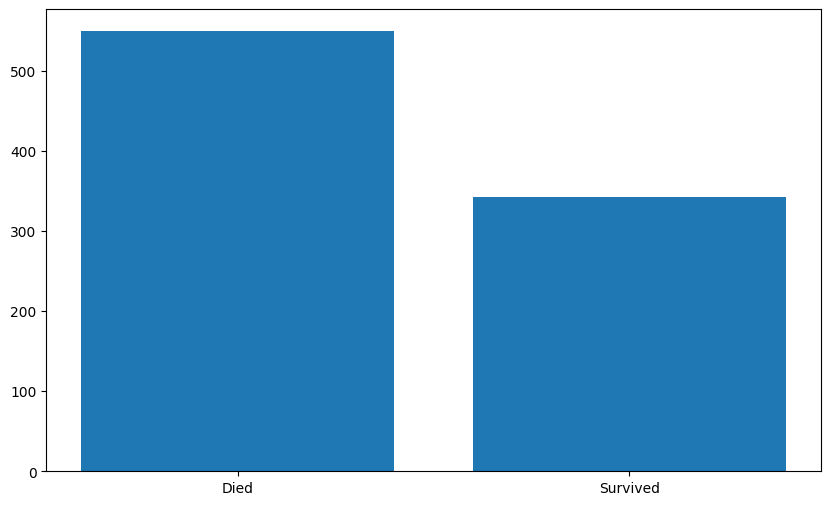

In [60]:
plt.figure(figsize=(10, 6))
survived_col = train_w['Survived'].map({0:'Died', 1:'Survived'}).value_counts().to_dict()
ax = plt.bar([key for key in survived_col.keys()], [value for value in survived_col.values()])
ax.set_title('Titanic Survival Distribution', fontsize=16)
ax.set_xlabel('Survival', fontsize=14)
plt.show()

## Numerical values

In [19]:
#Numerical data
numerical_cols = train_w[feature_names].describe().columns
numerical_cols = numerical_cols[~np.isin(numerical_cols, ['Sex', 'Pclass'])] #Sex and Pclass gets into this group for the transformation, they are categorical
train_w[numerical_cols].describe()  

,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.607178,0.523008,0.381594,32.204208
std,13.682805,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,37.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [20]:
def numerical_graphs(df, var):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    sns.histplot(df[var].dropna(), bins=30, kde=False, edgecolor='k', alpha=0.7, ax=axes[0])
    axes[0].set_title(f'{var} Distribution - Histogram')
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Frequency')
    
    sns.kdeplot(df[var].dropna(), ax=axes[1])
    axes[1].set_title(f'{var} Distribution - KDE')
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Density')
    
    sns.violinplot(y=df[var].dropna(), ax=axes[2])
    axes[2].set_title(f'{var} Distribution - Violin Plot')
    axes[2].set_xlabel('')  # No label for x-axis
    axes[2].set_ylabel(var)
    
    plt.tight_layout()
    plt.show()

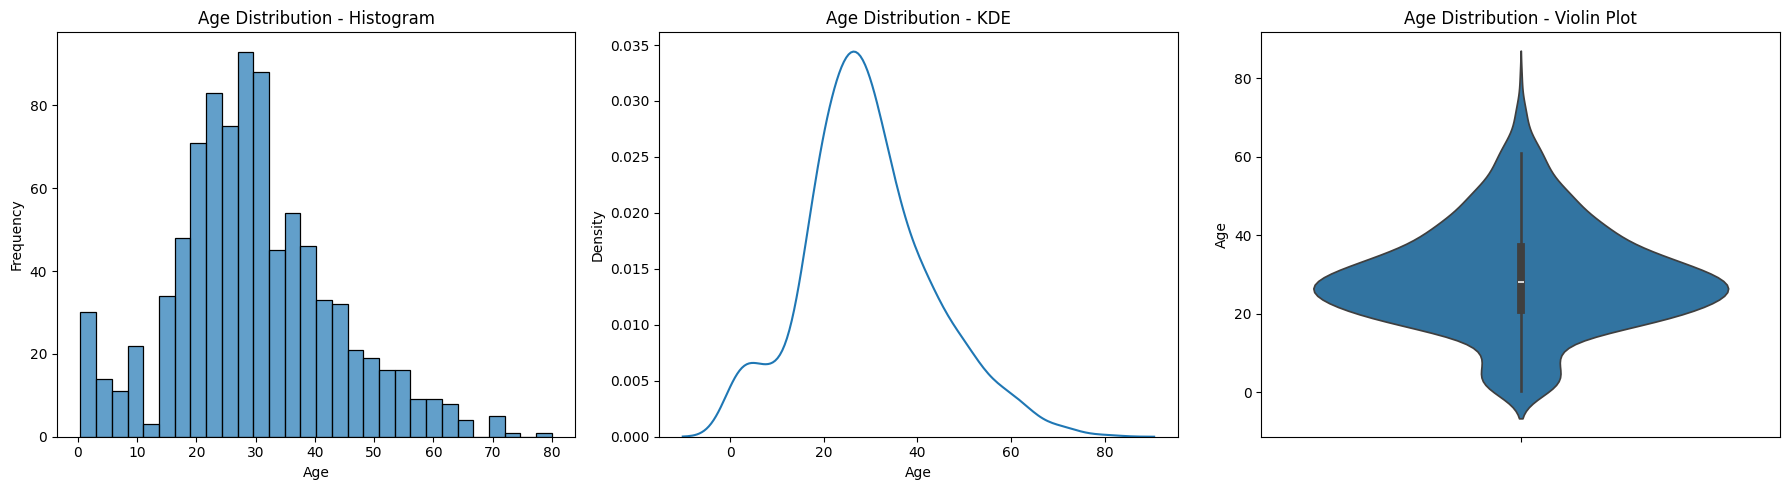

In [21]:
numerical_graphs(train_w, 'Age')

There is an important bias towards babies and some bimodality aswell. Other than that the range from 18 to 28 seems to be quite dominant between the passengers.

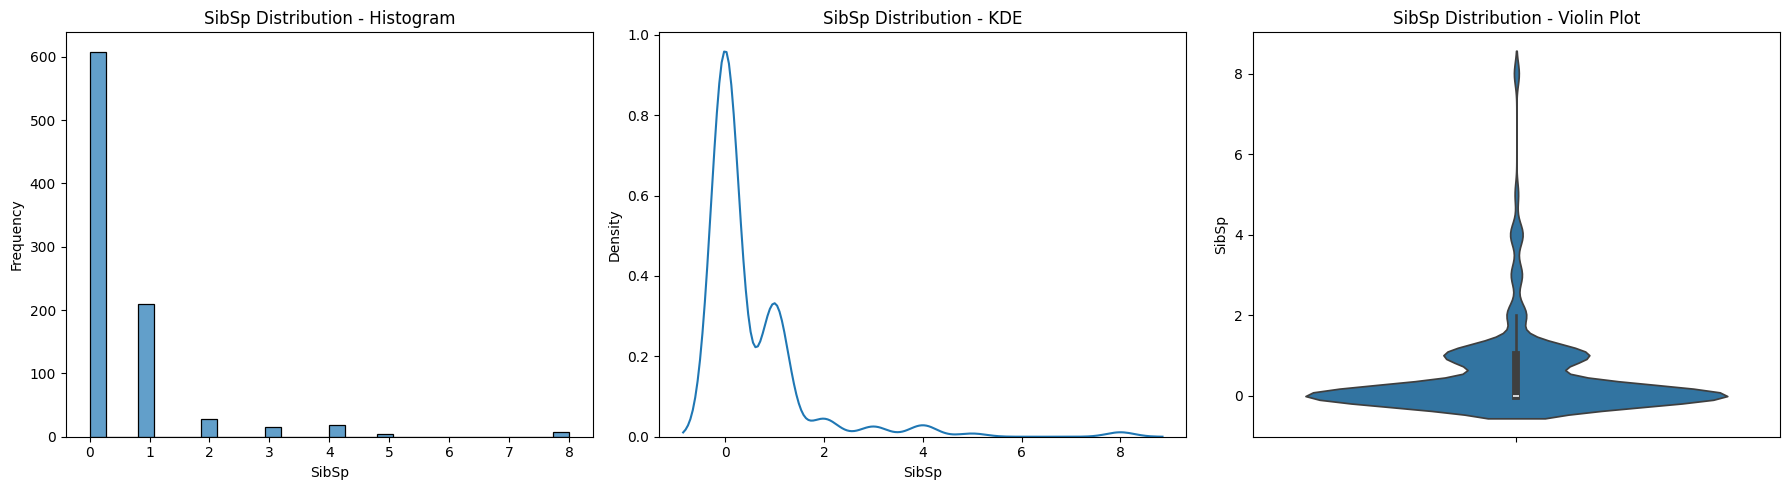

In [22]:
numerical_graphs(train_w, 'SibSp')

Being discrete values only the histogram makes any sense in this case. Otherwise, we could interpret the distribution as bimodal. On the other hand, it is clear that there is a large bias towards small values.

Big bias towards alone passengers.

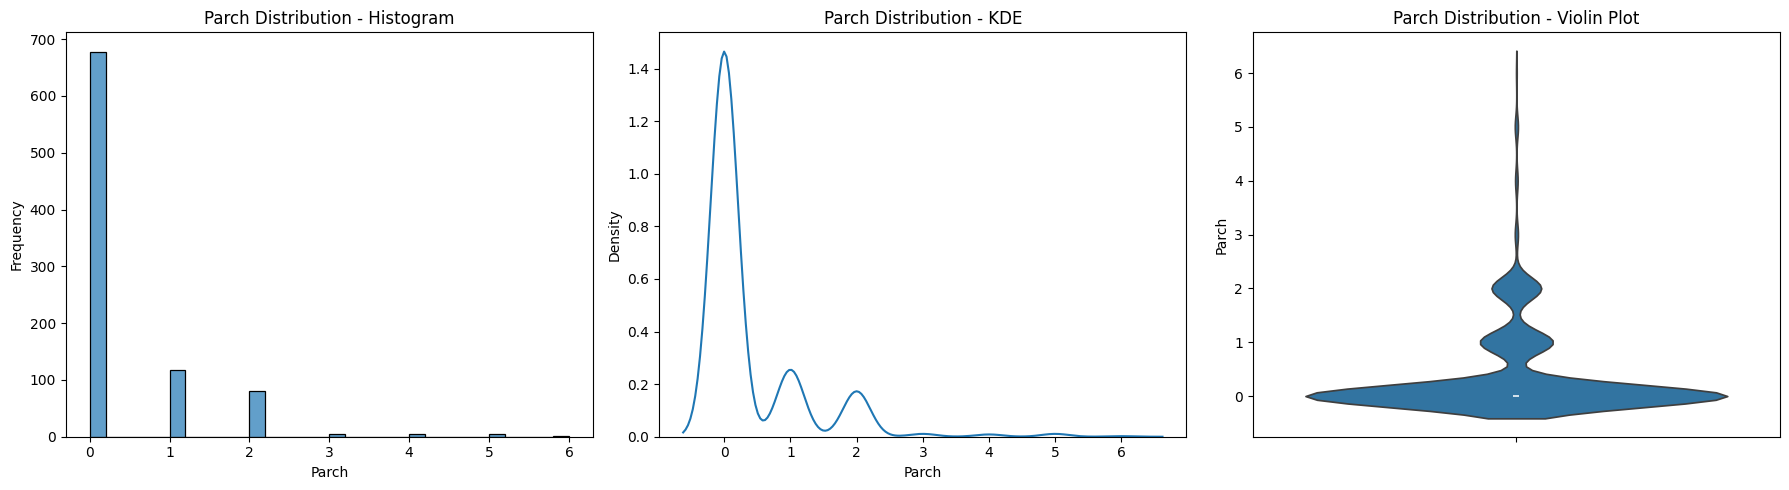

In [23]:
numerical_graphs(train_w, 'Parch')

Very similar to SibSp. It is important to remark that we could see this variables as categorical ordinal.

Big bias towards alone passengers aswell.

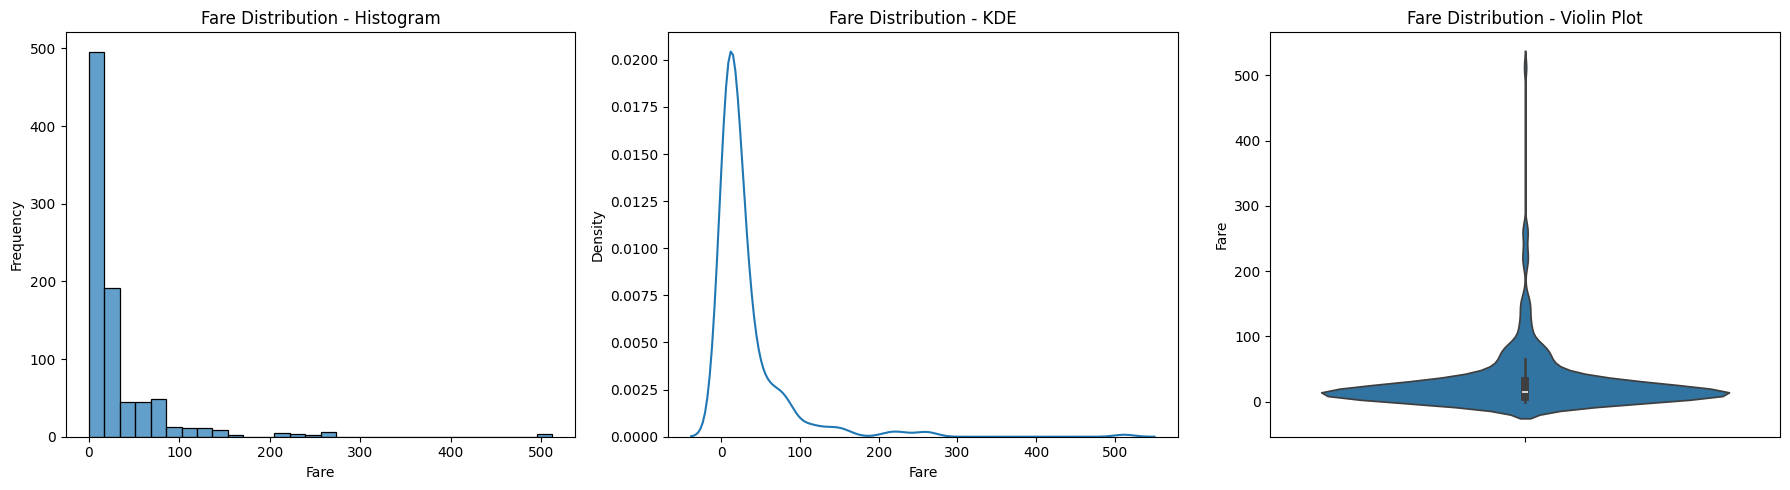

In [24]:
numerical_graphs(train_w, 'Fare')

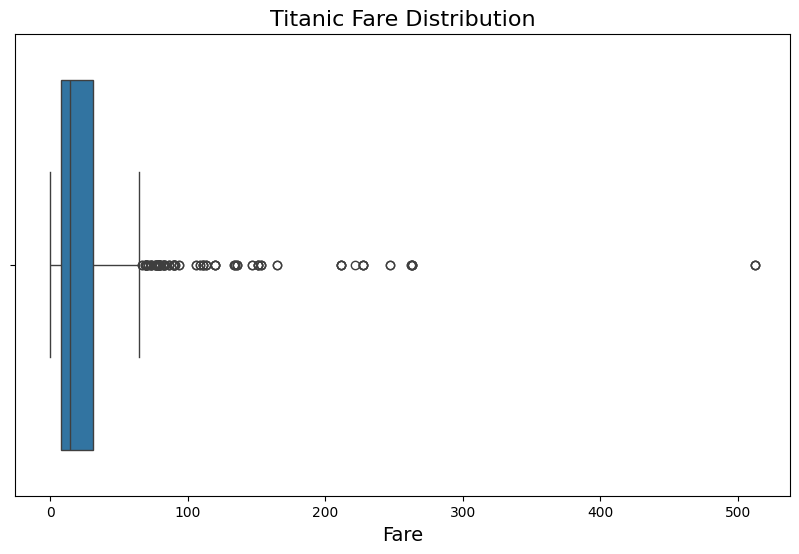

In [25]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x=train_w["Fare"])
ax.set_title('Titanic Fare Distribution', fontsize=16)
ax.set_xlabel('Fare', fontsize=14)
plt.show()

There are definitly some outliers. Maybe every value that goes beyond 80 should be considered an outlier. 

Given that The Titanic was a luxury ship those values could perfectly be valid. I will keep them just as they are, for this problem.

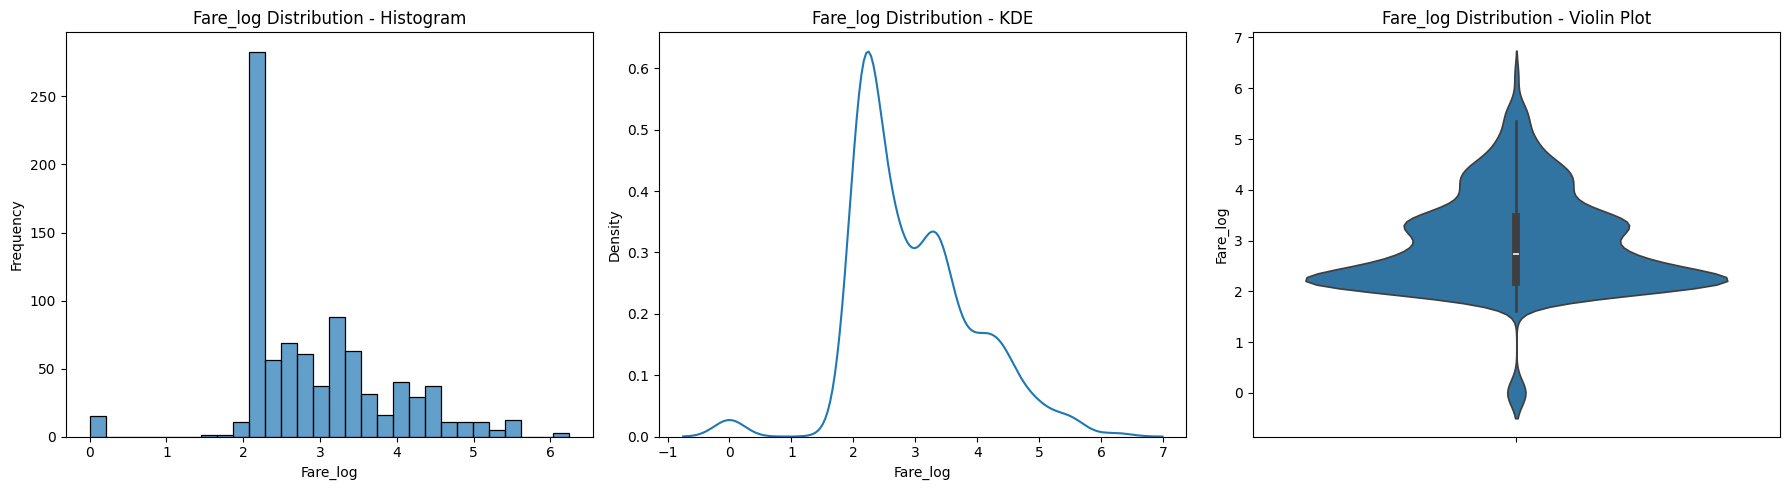

In [26]:
subset = train_w.copy()
subset['Fare_log'] = np.log1p(subset['Fare'])
numerical_graphs(subset, 'Fare_log')

There is a marked asymmetry to the left for cheap tickets.

This distribution probably has some outliers due to the rich passengers. Given that I am thinking to train a Random Forest model it shouldn't be necessary to use the log transformation in it, but it is helpfull here in the visualization

In [27]:
#I can add a composed feature for family relations

train_w['Family'] = train_w['SibSp'] + train_w['Parch']
familymap = {i:i for i in range(8)}
familymap[10] = 8 
train_w['Family'] = train_w['Family'].map(familymap)

test_w['Family'] = test_w['SibSp'] + test_w['Parch']
test_w['Family'] = test_w['Family'].map(familymap)

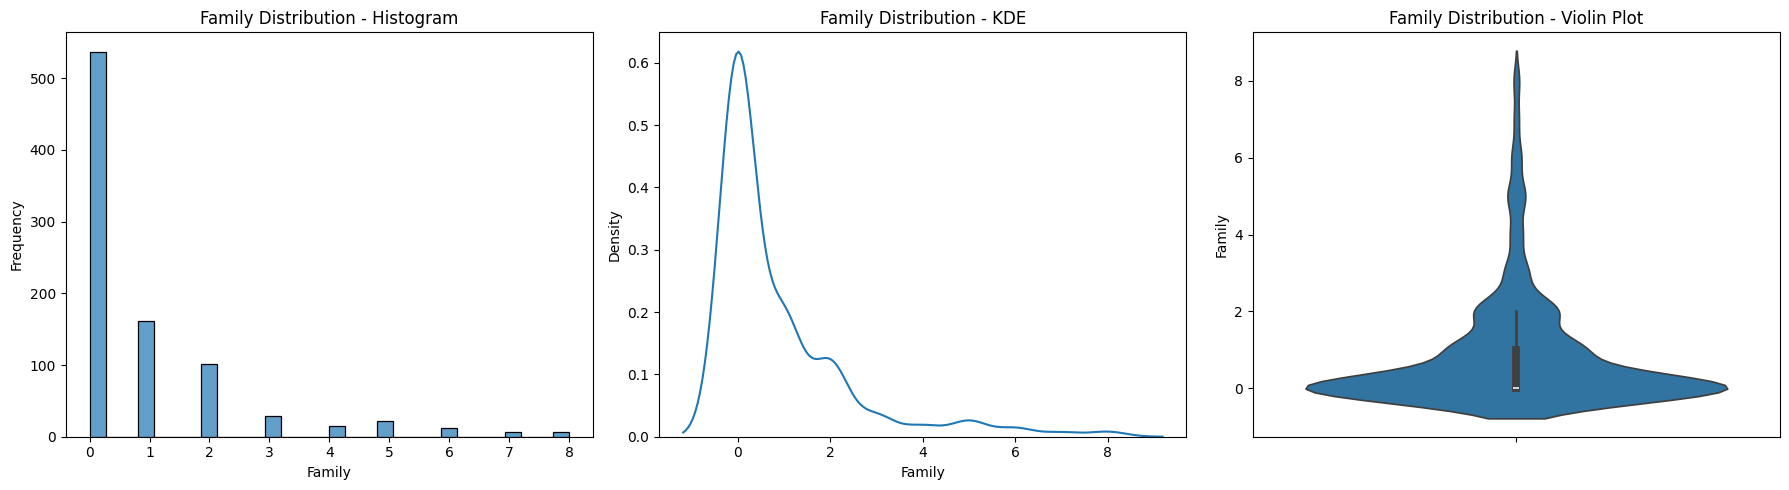

In [28]:
numerical_graphs(train_w, 'Family')

## Categorical values

Given that this is a small problem, I'll start adding engineered features first and then I will analyse them.

In [29]:
#We can create a feature by extracting the title of each person from the name

#col_index = train_w.columns.get_loc('Name')
#titulos = re.findall(pattern, train_w.iloc[30, col_index])

def get_title(entry):
    pattern = r'\b(Mr|Mrs|Miss|Master|Don|Lady|Sir|Dr|Rev|Capt|Jonkheer|Major|Mlle|Countess|Mme|Ms|Col)\.' 
    title = re.findall(pattern, entry)
    if title:
        return title[0]
    else: 
        return ''

train_w['Title'] = train_w['Name'].apply(get_title)
test_w['Title'] = test_w['Name'].apply(get_title)

#There is too much cardinality, so we group it
titlemap = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Mlle': 'Miss',
    'Mme': 'Mrs',
    'Ms': 'Miss',
    'Lady': 'Royalty',
    'Countess': 'Royalty',
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'Sir': 'Royalty',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty'
}

train_w['Title'] = train_w['Title'].map(titlemap)
test_w['Title'] = test_w['Title'].map(titlemap)

In [30]:
test_w['Title'].value_counts()

Title
Mr         240
Miss        79
Mrs         72
Master      21
Officer      5
Name: count, dtype: int64

In [31]:
train_w.loc[train_w['Title'] != 'Mr'].value_counts().sum()

np.int64(374)

There is a dominant presence of the first class "Mr" which or far greater that the rest combined

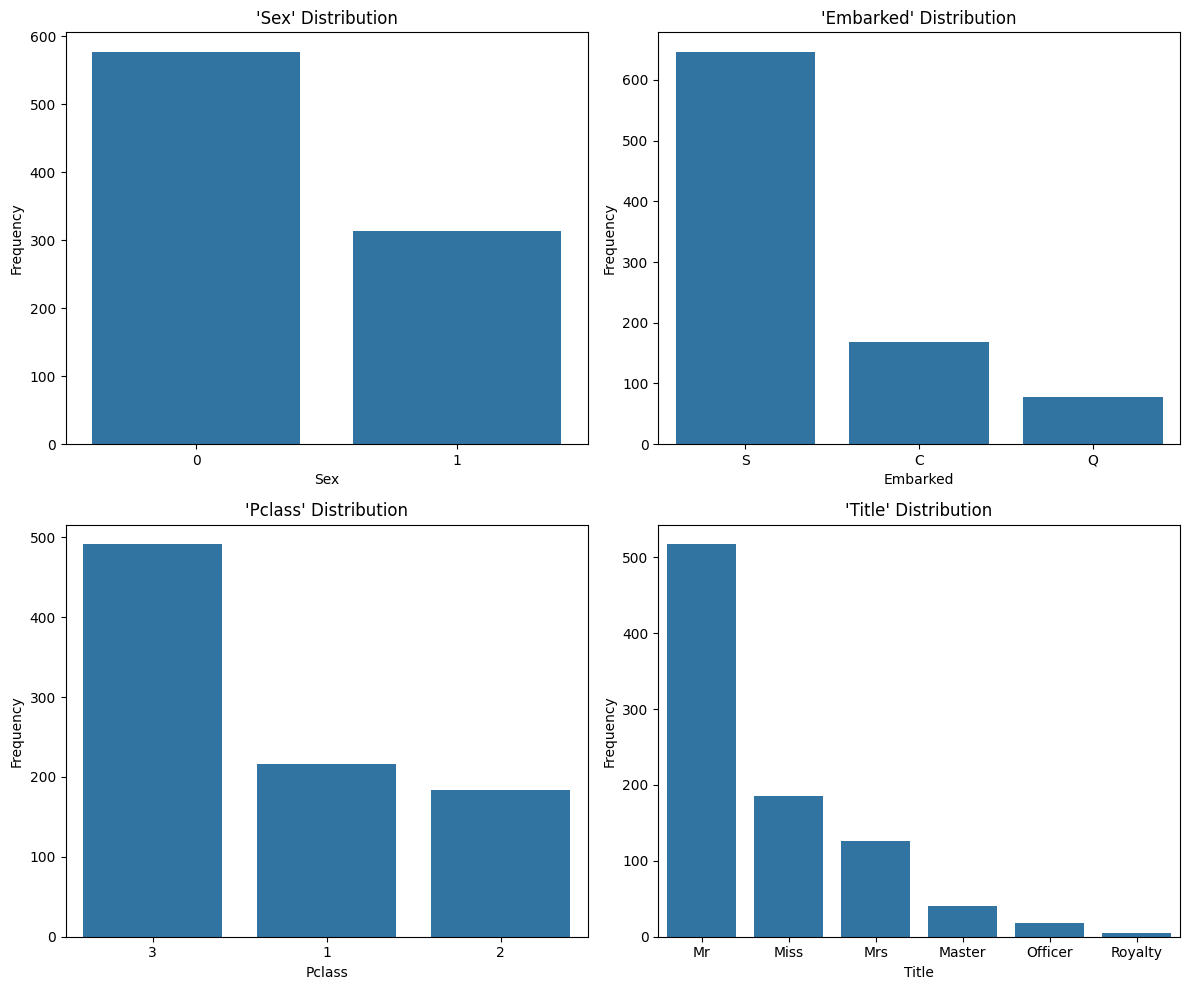

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(data=train_w, x='Sex', 
              order=train_w['Sex'].value_counts().index, ax=axs[0, 0])
axs[0, 0].set_title("'Sex' Distribution")
axs[0, 0].set_xlabel("Sex")
axs[0, 0].set_ylabel("Frequency")

sns.countplot(data=train_w, x='Embarked', 
              order=train_w['Embarked'].value_counts().index, ax=axs[0, 1])
axs[0, 1].set_title("'Embarked' Distribution")
axs[0, 1].set_xlabel("Embarked")
axs[0, 1].set_ylabel("Frequency")

sns.countplot(data=train_w, x='Pclass', 
              order=train_w['Pclass'].value_counts().index, ax=axs[1, 0])
axs[1, 0].set_title("'Pclass' Distribution")
axs[1, 0].set_xlabel("Pclass")
axs[1, 0].set_ylabel("Frequency")

sns.countplot(data=train_w, x='Title', 
              order=train_w['Title'].value_counts().index, ax=axs[1, 1])
axs[1, 1].set_title("'Title' Distribution")
axs[1, 1].set_xlabel("Title")
axs[1, 1].set_ylabel("Frequency")

fig.tight_layout()

plt.show()

Family has also a great bias toward the first class, but I am thinking to train a RandomForest clasifier so I shouldn't care to much unless I had too bad results.

We found dominance from one class for every single value. There is a lot of biases around this dataset. We could fabricate synthetic data if the model gets poor results, but I think that must come first, because we have to check the reach of the RandomForest model first.

We could picture the stereotipical passenger of this trip as a 3rd class male between the age of 20 and 30 who travels alone.

In [33]:
#Categorical data
categorical_cols = train_w[feature_names].describe(include='object').columns
categorical_cols = np.append(categorical_cols, ['Sex', 'Pclass', 'Title', 'Family']) #Those that got left behind
subset = train_w.copy()
subset['Sex'] = train_w['Sex'].map({0 : 'male', 1 : 'female'})
subset['Pclass'] = train_w['Pclass'].map({1 : 'first', 2 : 'second', 3 : 'third'})
subset[categorical_cols].describe(include='object') 

,Ticket,Cabin,Embarked,Sex,Pclass,Title
count,891,891,891,891,891,891
unique,681,148,3,2,3,6
top,347082,unknown,S,male,third,Mr
freq,7,687,646,577,491,517


This description reveals a notable dominance of class 3, a higher proportion of male passengers, and a large number of people traveling without siblings/spouses or parents/children on board. In addition, cabin information is largely absent.

Sex is already a one hot encoded value, so we leave it like that. Pclass, which is categorical is also ordinal, so we can again leave it be like that

In [34]:
#There is a lot of cabin numbers, maybe I could take the deck in a similar way that I did with the title
train_w['Deck'] = train_w['Cabin'].str[0]
train_w.fillna({'Deck':'Unknown'}, inplace=True)
print(train_w['Deck'].value_counts())
categorical_cols = np.append(categorical_cols, ['Deck'])

test_w['Deck'] = test_w['Cabin'].str[0]
test_w.fillna({'Deck':'Unknown'}, inplace=True)

Deck
u    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


# Bivariate analysis

## Numerical variables

<Axes: >

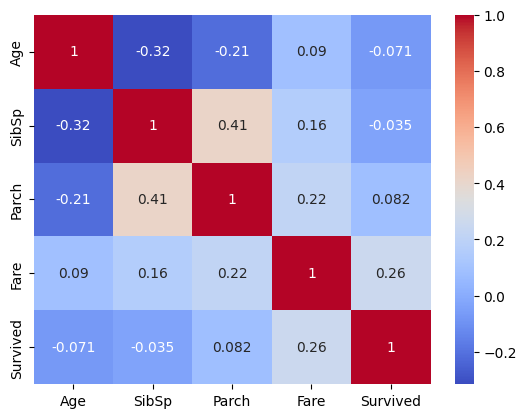

In [35]:
sns.heatmap(train_w[np.append(numerical_cols, ['Survived'])].corr(), annot=True, cmap='coolwarm')

There is a "strong" overal correlation between Fare and survival, leaning towards a better chance increasing with the price of the ticket. It doesnt show too much for the age variable, but this could be due to a sum of different tendencies.

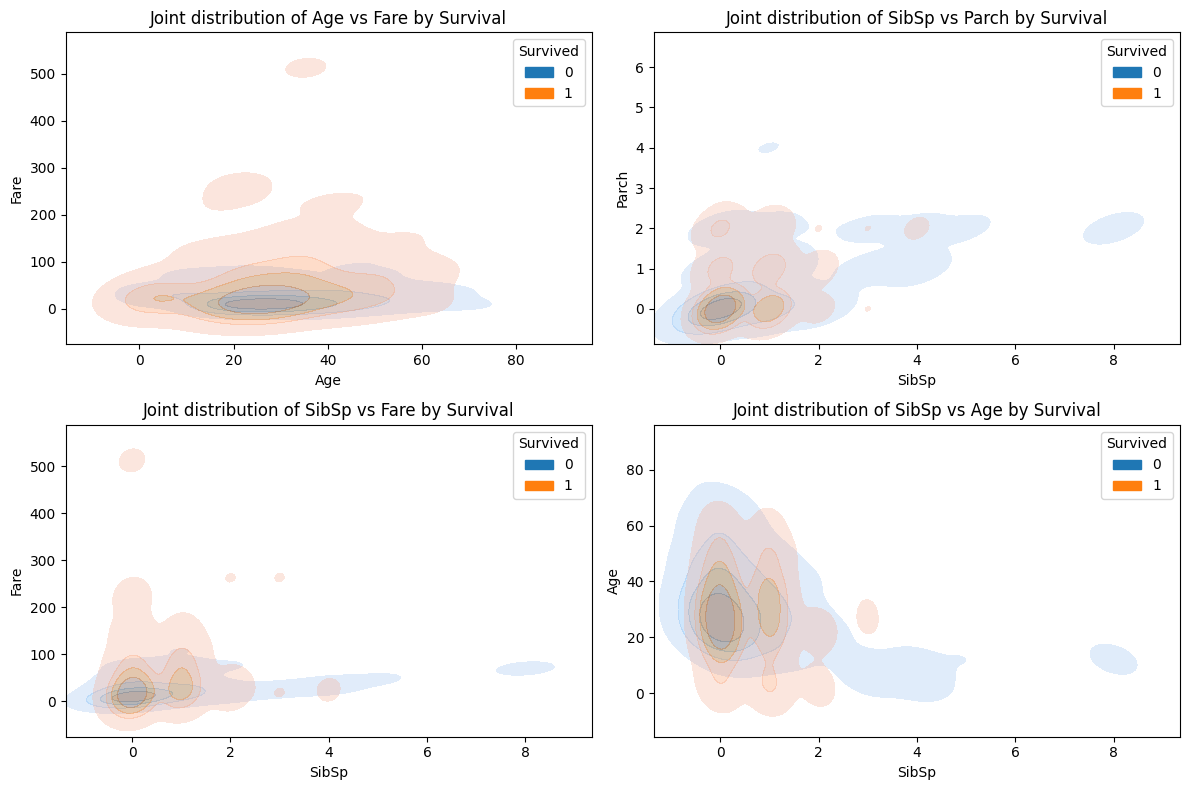

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
pairs = [('Age', 'Fare'), ('SibSp', 'Parch'), ('SibSp', 'Fare'), ('SibSp', 'Age')]

for ax, (var1, var2) in zip(axes, pairs):
    sns.kdeplot(
        data=train_w,
        x=var1, 
        y=var2,
        hue='Survived',
        levels=5,           
        common_norm=False,  
        fill=True,          
        alpha=0.3,          
        ax=ax
    )
    ax.set_title(f'Joint distribution of {var1} vs {var2} by Survival')

plt.tight_layout()
plt.show()

These cases correspond to those with high correlation in the matrix. Here there are some differences, from which the SibSp variable tends to show some clustering

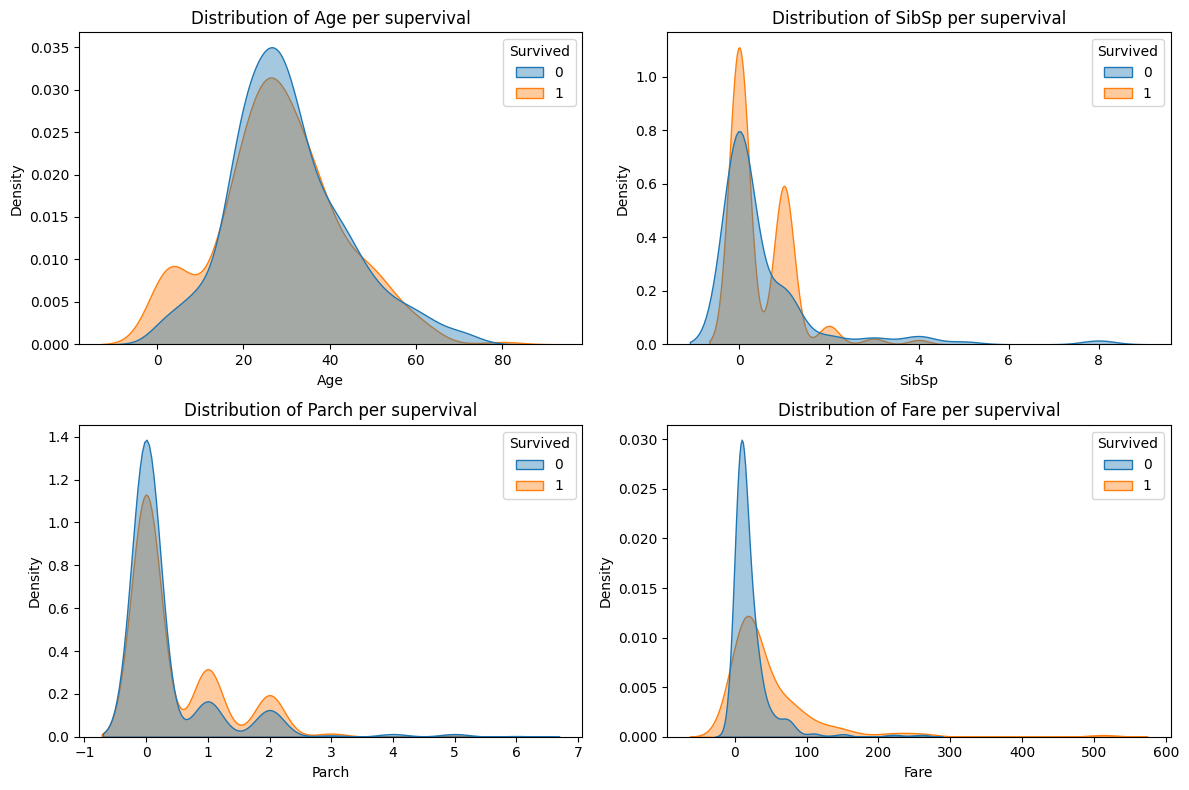

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, var in zip(axes, numerical_cols):
    sns.kdeplot(
        data=train_w, x=var,
        hue='Survived',
        common_norm=False,       # normalizar cada curva por separado
        fill=True,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f'Distribution of {var} per supervival')
plt.tight_layout()

There are some differences between each variable distribution towards the objective. This means that there are patterns to be found that could be characterized. The variables of SibSp and Fare seems to be the ones with more differences making them the more informative for survival.

For the two "most numerical" variables (this is, the least close to an ordinal categorical variable), Age and Fare, we can make groups to check if we could discretizise them

In [38]:
subset = train_w.copy()
age_bins = [0, 3, 12, 18, 35, 60, np.inf]
age_labels = ['Toddler', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
subset['Age_group'] = pd.cut(subset['Age'], bins=age_bins, labels=age_labels, right=False)

age_group_dummies = pd.get_dummies(subset['Age_group'], prefix='AgeGroup')
subset = pd.concat([subset, age_group_dummies.astype(int)], axis=1)
newlabels = [f'AgeGroup_{label}' for label in age_labels]
newlabels.append('Survived')
subset[newlabels].corr()

,AgeGroup_Toddler,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Survived
AgeGroup_Toddler,1.000000,-0.041842,-0.041842,-0.183085,-0.103039,-0.028845,0.082505
AgeGroup_Child,-0.041842,1.000000,-0.063246,-0.276741,-0.155748,-0.043601,0.045434
AgeGroup_Teenager,-0.041842,-0.063246,1.000000,-0.276741,-0.155748,-0.043601,0.035677
AgeGroup_Young Adult,-0.183085,-0.276741,-0.276741,1.000000,-0.681495,-0.190781,-0.071004
AgeGroup_Adult,-0.103039,-0.155748,-0.155748,-0.681495,1.000000,-0.107370,0.021612
AgeGroup_Senior,-0.028845,-0.043601,-0.043601,-0.190781,-0.107370,1.000000,-0.040857
Survived,0.082505,0.045434,0.035677,-0.071004,0.021612,-0.040857,1.000000


Here there is not much to be found, so we move ahead with this excercise

In [39]:
subset = train_w.copy()
fare_bins = [0, 8, 15, 31, np.inf]
fare_labels = ['Very Low', 'Low', 'Medium', 'High']
subset['Fare_group'] = pd.cut(subset['Age'], bins=fare_bins, labels=fare_labels, right=False)

fare_group_dummies = pd.get_dummies(subset['Fare_group'], prefix='Fare_group')
subset = pd.concat([subset, fare_group_dummies.astype(int)], axis=1)
newlabels = [f'Fare_group_{label}' for label in fare_labels]
newlabels.append('Survived')
subset[newlabels].corr()

,Fare_group_Very Low,Fare_group_Low,Fare_group_Medium,Fare_group_High,Survived
Fare_group_Very Low,1.000000,-0.053551,-0.239759,-0.201704,0.148489
Fare_group_Low,-0.053551,1.000000,-0.215959,-0.181681,-0.030152
Fare_group_Medium,-0.239759,-0.215959,1.000000,-0.813419,-0.055955
Fare_group_High,-0.201704,-0.181681,-0.813419,1.000000,0.000237
Survived,0.148489,-0.030152,-0.055955,0.000237,1.000000


Interestingly, there is a higher correlation with survival at a lower price. This, although it is a numerical variable could be turned into a categorical.
More interesting than that the correlation droped in both cases, Age and Fare, so I won't persist with this strategy anymore.

More important than that, this variable has a lot of outliers, so having some groups will help with those values.

## Categorical variables

In [40]:
table = PrettyTable()
table.field_names = ['Variable', 'Chi2 stat', 'p value', 'dof']
for variable in categorical_cols:
    contingency_table = pd.crosstab(train_w[variable], train_w['Survived'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    table.add_row([variable, f'{chi2_stat:.2f}', f'{p_value:.4f}', dof])

print(table)

+----------+-----------+---------+-----+
| Variable | Chi2 stat | p value | dof |
+----------+-----------+---------+-----+
|  Ticket  |   766.57  |  0.0115 | 680 |
|  Cabin   |   241.00  |  0.0000 | 147 |
| Embarked |   25.96   |  0.0000 |  2  |
|   Sex    |   260.72  |  0.0000 |  1  |
|  Pclass  |   102.89  |  0.0000 |  2  |
|  Title   |   289.84  |  0.0000 |  5  |
|  Family  |   80.67   |  0.0000 |  8  |
|   Deck   |   99.16   |  0.0000 |  8  |
+----------+-----------+---------+-----+


Every single variable has a very low p value. This means that in each case we cannot discart the cero hypotesis, so there must be a relation between survival chance and each variable.

For this is strange that even the embarked door has some relation, but that maybe because of the way that the ship sinked.

In [41]:
def cramers_v(x, y):
    ct = pd.crosstab(x, y).values
    chi2 = chi2_contingency(ct)[0]
    n = ct.sum()
    k = min(ct.shape)
    return np.sqrt(chi2/(n*(k-1)))

table = PrettyTable()
table.field_names = ['Variable', 'Cramers V.']
for variable in ['Sex','Pclass','Embarked','Title','Family','Deck']:
    table.add_row([variable, f'{cramers_v(train_w[variable], train_w.Survived):.4f}'])

print(table)

+----------+------------+
| Variable | Cramers V. |
+----------+------------+
|   Sex    |   0.5409   |
|  Pclass  |   0.3398   |
| Embarked |   0.1707   |
|  Title   |   0.5703   |
|  Family  |   0.3009   |
|   Deck   |   0.3336   |
+----------+------------+


The chi^2 test can help with independence but for derive strenght in the relation it is better to calculate Cramer’s V

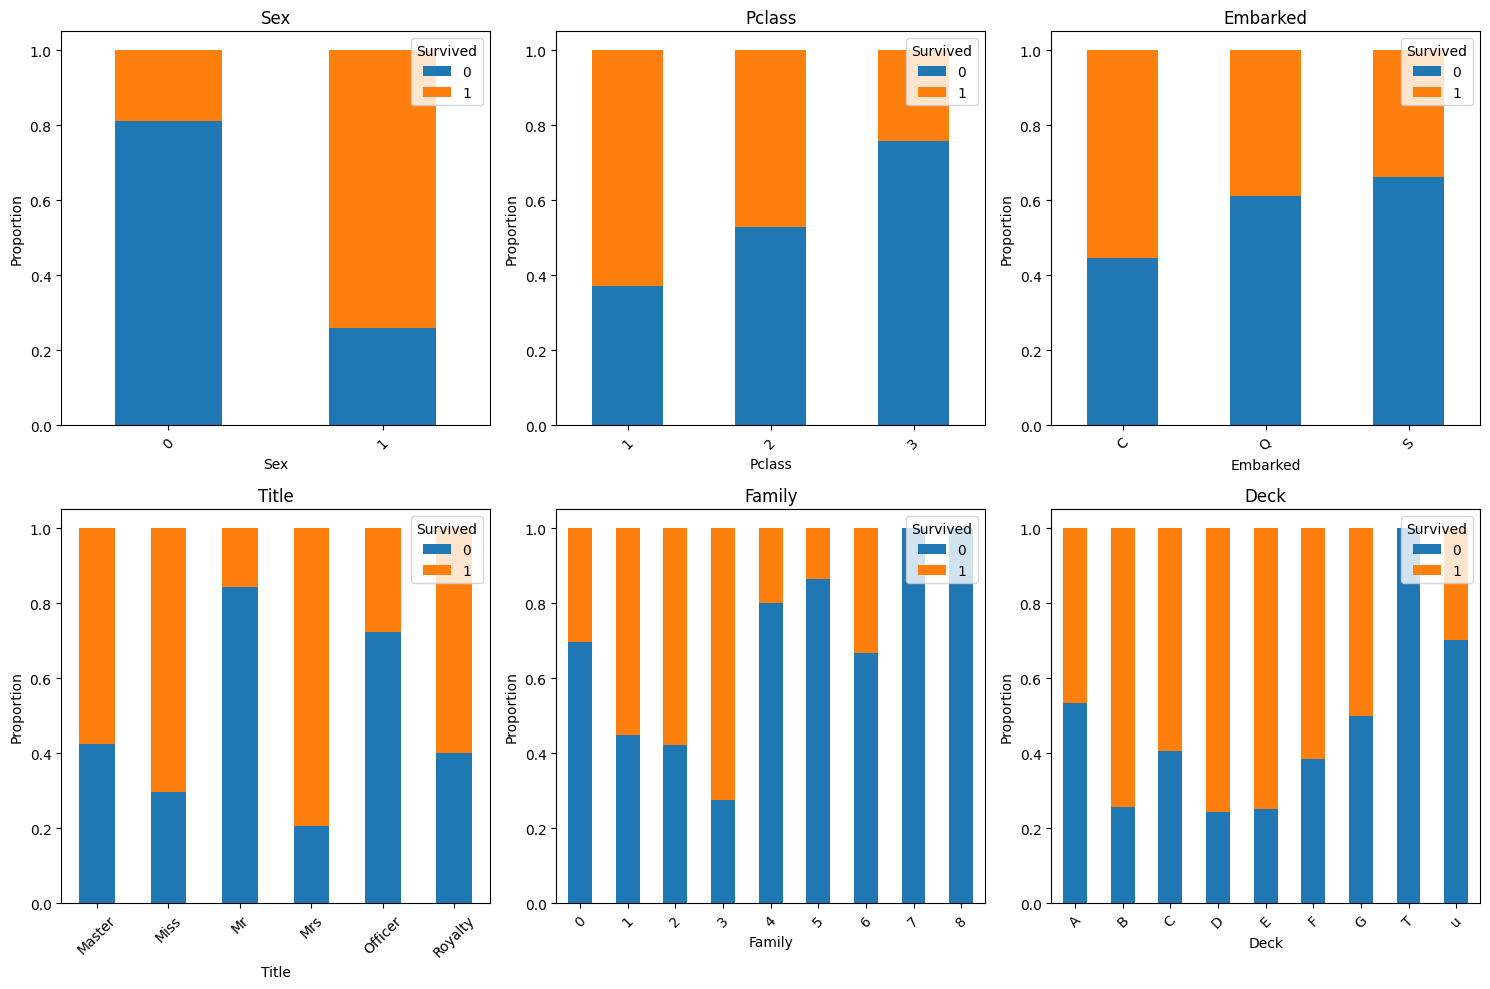

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()
cats = ['Sex','Pclass','Embarked','Title','Family','Deck']

for ax, var in zip(axes,cats):
    ct = pd.crosstab(train_w[var], train_w.Survived, normalize='index')
    ct.plot(kind='bar', stacked=True, ax=ax)
    ax.set_ylabel('Proportion')
    ax.set_title(var)
    ax.legend(title='Survived', loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

There is an important survival rate increment chance for being a woman and having a family between 1 to 3 members. Offcourse, being a high class passenger also increases survival chances. It is shoking that no one with more than 6 family members survived, maybe failing at trying to save them all, we cannot trully say. Also this is true for everyone who was on T deck.

In [43]:
subset = train_w.copy()

subset['TicketPrefix'] = (
    train_w.Ticket
         .str.extract(r'([A-Za-z\.\/]+)', expand=False)
         .fillna('NONE')
)
top10 = subset['TicketPrefix'].value_counts().nlargest(10).index
subset['TicketPrefix2'] = subset['TicketPrefix'].where(
    subset['TicketPrefix'].isin(top10), 'OTHER'
)

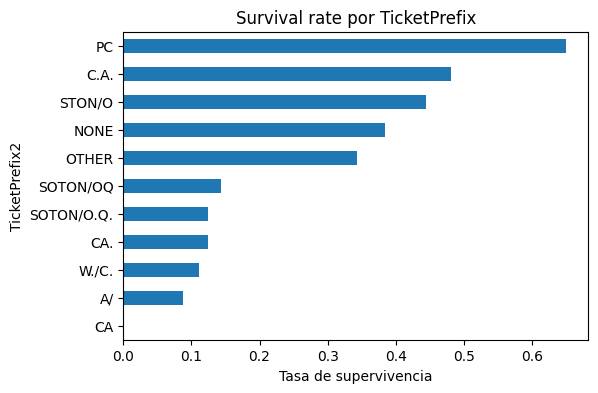

In [44]:
rates = (
    subset
    .groupby('TicketPrefix2')['Survived']
    .mean()
    .sort_values()
)
rates.plot(kind='barh', figsize=(6,4))
plt.xlabel('Tasa de supervivencia')
plt.title('Survival rate por TicketPrefix')
plt.show()

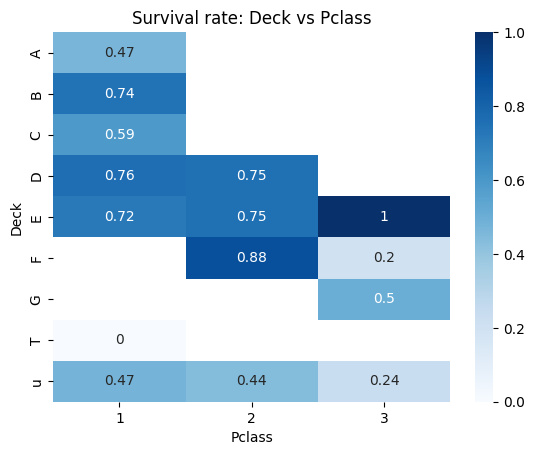

In [45]:
tmp = (
    subset
    .groupby(['Deck','Pclass'])['Survived']
    .mean()
    .unstack()
)
sns.heatmap(tmp, annot=True, cmap='Blues')
plt.title('Survival rate: Deck vs Pclass')
plt.show()

In [46]:
dataset_path = 'E:/Datasets/titanic/wrangled dataset'

In [47]:
train_w['TicketPrefix'] = subset['TicketPrefix2']
subset = test_w.copy()

subset['TicketPrefix'] = (
    test_w.Ticket
         .str.extract(r'([A-Za-z\.\/]+)', expand=False)
         .fillna('NONE')
)
top10 = subset['TicketPrefix'].value_counts().nlargest(10).index
subset['TicketPrefix2'] = subset['TicketPrefix'].where(
    subset['TicketPrefix'].isin(top10), 'OTHER'
)
test_w['TicketPrefix'] = subset['TicketPrefix2']

In [49]:
train_w.to_csv(f'{dataset_path}/train.csv', index=False)
test_w.to_csv(f'{dataset_path}/test.csv', index=False)

# Conclusions

This dataset shows a reasonable amount of data to train a classical machine learning model. 

There are a lot of simple biases towards dominant modes in each variable. This can create a single cluster for the stereotypical profile of a passenger, making some of the categorization difficult on the least rich variables.

It is possible to do simple feature engineering to some of the most sparse variables, like the names and the tickets. 

There are some non-linearities and a few outliers. 

The variables should be enough to explain the target value. 

For these dataset a lot of machine learning models could handle the job well, but preprocessing (normalizing most of it) should be done according to the chosen model. Random Forest should be a good option